<a href="https://colab.research.google.com/github/leticiaram/Modelacion-Epidemiologica/blob/main/5_Stan_in_Colab_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Runing Stan in Colab


Part of this code is derived from the

**CmdStanPy Example Notebook**

https://colab.research.google.com/github/stan-dev/example-models/blob/master/knitr/cloud-compute-2020/CmdStanPy_Example_Notebook.ipynb

 **display_of_mcmc_samples**

https://colab.research.google.com/github/bebi103b/bebi103b.github.io/blob/master/lessons/11/display_of_mcmc_samples.ipynb#scrollTo=ov_yzWdgf0II

and

 **Bayesian workflow for disease transmission modeling in Stan**

https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html


**L. Leticia Ramírez-Ramírez**

# Loading the packages and programs

This notebook demonstrates
- How to install the [CmdStanPy](https://cmdstanpy.readthedocs.io/en/latest/index.html) toolchain on a Google Colab instance and verify the installation by running the Stan NUTS-HMC sampler on the example model and data which are included with CmdStan.
- Two examples of stan

In [ ]:
# Colab setup ------------------
import os, shutil, sys, subprocess, urllib.request
if "google.colab" in sys.modules:
    cmd = "pip install --upgrade iqplot colorcet datashader bebi103 arviz cmdstanpy watermark"
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    from cmdstanpy.install_cmdstan import latest_version
    cmdstan_version = latest_version()
    cmdstan_url = f"https://github.com/stan-dev/cmdstan/releases/download/v{cmdstan_version}/"
    fname = f"colab-cmdstan-{cmdstan_version}.tgz"
    urllib.request.urlretrieve(cmdstan_url + fname, fname)
    shutil.unpack_archive(fname)
    os.environ["CMDSTAN"] = f"./cmdstan-{cmdstan_version}"
    data_path = "https://s3.amazonaws.com/bebi103.caltech.edu/data/"
else:
    data_path = "../data/"
# ------------------------------




In [ ]:
# Load packages used in this notebook

import json
import pandas as pd

import numpy as np
import cmdstanpy
import arviz as az

import iqplot
import bebi103

import bokeh.io
bokeh.io.output_notebook()

In [ ]:
!pip show cmdstanpy

Name: cmdstanpy
Version: 1.2.4
Summary: Python interface to CmdStan
Home-page: https://github.com/stan-dev/cmdstanpy
Author: Stan Dev Team
Author-email: 
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, pandas, stanio, tqdm
Required-by: bebi103, prophet


In [ ]:
%load_ext watermark
%watermark -v -p numpy,pandas,cmdstanpy,arviz,bokeh,iqplot,bebi103,jupyterlab
print("cmdstan   :", bebi103.stan.cmdstan_version())

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy     : 1.26.4
pandas    : 2.2.2
cmdstanpy : 1.2.4
arviz     : 0.20.0
bokeh     : 3.4.3
iqplot    : 0.3.7
bebi103   : 0.1.25
jupyterlab: not installed

cmdstan   : 2.35.0


# First Example: Bernoulli model

The CmdStan installation includes a simple example program `bernoulli.stan` and test data `bernoulli.data.json`. These are in the CmdStan installation directory `examples/bernoulli`. However here directly specify the model and data.


**Model**

We have $n$ observations of *successes* and *failures*. If we assume that the results are independent and the probability of *success* in each observation is $\theta$, the model we can consider is Bernoulli$(\theta)$, so likelihood is:
$$
p(\boldsymbol{x}|\theta)\propto \prod_{i=1}^n\theta^{x_i}(1-\theta)^{1-x_i}=\theta^{\sum_{i=1}^n x_i}(1-\theta)^{n-\sum_{i=1}^nx_i}
$$
We want to obtain simulations from the posterior:
$$
\pi(\theta|\boldsymbol{x})\propto p(\boldsymbol{x}|\theta)\pi(\theta)
$$
with prior as:
$$
\pi(\theta) \sim U(0,1) \quad (\sim \text{Beta}(1,1))
$$

In [ ]:
bernoulli_stan = """
data {
  int<lower=0> N;
  array[N] int<lower=0,upper=1> y;
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);  // uniform prior on interval 0,1
  y ~ bernoulli(theta);
}
"""
with open("bernoulli.stan", "w") as f:
    f.write(bernoulli_stan)

The data file `bernoulli.data.json` contains 10 observations, split between 2 successes (1) and 8 failures (0).

In [ ]:
bernoulli_data = dict(
    N=10,
    y=np.array([1, 0, 1, 1, 1, 0, 0, 0, 0, 1]),
)


In [ ]:
bernoulli_data

{'N': 10, 'y': array([1, 0, 1, 1, 1, 0, 0, 0, 0, 1])}

## Testing CmdStanPy

The following code test that the CmdStanPy toolchain is properly installed by compiling the example model, fitting it to the data, and obtaining a summary of estimates of the posterior distribution of all parameters and quantities of interest.



In [ ]:
# Run CmdStanPy Hello, World! example
from cmdstanpy import cmdstan_path, CmdStanModel

## Compiling and runing the model

A **CmdStanModel** object encapsulates the Stan program. **sample()**
runs the HMC-NUTS sampler to produce a set of draws from the posterior distribution. More in https://mc-stan.org/cmdstanpy/api.html


In [ ]:
with bebi103.stan.disable_logging():
    sm = cmdstanpy.CmdStanModel(stan_file="bernoulli.stan")

    samples = sm.sample(
        data = bernoulli_data,
        chains = 4,
        iter_sampling = 1000,
    )

samples = az.from_cmdstanpy(posterior=samples)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

## Examining traces

The first type of visualization we will explore is useful for diagnosing potential problems with the sampler.

### Trace plots

Trace plots are a common way of visualizing the trajectory a sampler takes through parameter space. We plot the value of the parameter versus step number. You can make these plots using bebi103.viz.trace_plot(). By default, the traces are colored according to chain number. In our sampling we just did, we used Stan's default of four chains.

To make plots with ArviZ, the basic syntax is az.plot_***(samples, backend='bokeh'), where *** is the kind of plot you want. The backend="bokeh" kwarg indicates that you want the plot rendered with Bokeh. Let's make a trace plot.

In [ ]:
az.plot_trace(samples, backend="bokeh",figsize=[13,4],compact=False);

In [ ]:
az.plot_trace(samples, backend="bokeh",figsize=[13,4]);



ArviZ generates two plots for each variable. The plots to the right show the trace of the sampler. In this plot, the x-axis is the iteration number of the steps of the walker and the y-axis is the values of the parameter for that step.

ArviZ also plots a picture of the marginalized posterior distribution for each trace to the left. The issue I have these plots because they use kernel density estimation for the posterior plot. KDE involves selecting a bandwidth, which leaves an adjustable parameter. One option is simply to plot the ECDFs of the samples to visualize the marginal distributions.


To make trace plots with the bebi103 module, you can do the following.

In [ ]:
bokeh.io.show(bebi103.viz.trace(samples))

These trace plots look pretty good; the sampler is bounding around a central value. Trace plots are very commonly used, which is why I present them here, but are not particularly useful. This is not just my opinion. Here is what Dan Simpson has to say about trace plots.

### Plotting marginalized distribution with ArviZ

We already saw that ArviZ can give these plots along with trace plots. We can also directly plot them using the az.plot_density(). When using this function, the distributions are truncated at the bound of the highest probability density region, or HPD. If we're considering a 95% credible interval, the HPD interval is the shortest interval that contains 95% of the probability of the posterior. By default, az.plot_density() truncates the plot of the KDE of the PDF for a 94% HPD.

In [ ]:
az.plot_density(
    samples, backend="bokeh", backend_kwargs=dict(frame_width=200, frame_height=150)
);

To get samples out of the marginalized posterior for a single parameter, we simply ignore the values of the parameters that are not the one of interest. We can then use iqplot to make plots of histograms or ECDFs.

To do so, we need to convert the posterior samples to a tidy data frame.

In [ ]:
# Convert to data frame
df_mcmc = bebi103.stan.arviz_to_dataframe(samples)

# Take a look
df_mcmc.head()

theta,chain__,draw__,diverging__
f64,i64,i64,bool
0.3573,0,0,false
0.495464,0,1,false
0.40206,0,2,false
0.423356,0,3,false
0.395207,0,4,false


Now, we can use iqplot to make histograms.

In [ ]:
hists = [
    iqplot.histogram(
        df_mcmc, q=param, density=True, rug=False, frame_height=150
    )
    for param in ["theta"]
]

bokeh.io.show(bokeh.layouts.column(*hists))

Another option is depicting the ECDFs of the samples


In [ ]:
ecdfs = [
    iqplot.ecdf(
        df_mcmc, q=param, style="staircase", frame_height=150
    )
    for param in ["theta"]
]

bokeh.io.show(bokeh.layouts.column(*ecdfs))

# Second Example: SIR model

The flow across states follows the path $ S  \to I \to R $.





<a id='equation-sir-system'></a>
$$
\begin{aligned}
     \dot S(t)  & = - \beta \, S(t) \,  I(t)
     \\
     \dot I(t)  & = \beta \,  S(t) \,  I(t)  - \gamma I(t)
     \\
     \dot R(t)  & =  \gamma I(t)
\end{aligned} \tag{1.1}
$$

In these equations,

- $ \beta(t) \quad$  is called the *transmission rate* (the rate at which individuals bump into others and expose them to the virus).  
- $ \gamma \qquad$ is called the *recovery rate* (the rate at which infected people recover or die).  



We will also track $ C = I + R $, which is the cumulative caseload
(i.e., all those who have or have had the infection).

The system [(1.1)](#equation-sir-system) can be written in vector form as

<a id='equation-dfcv'></a>
$$
\dot x = F(x, t),  \qquad x := (S, I, R) \tag{1.2}
$$

for suitable definition of $ F $ (see the code below).

## Data simulation

We simulate the data considering the model Negative Binomial with pdf
$$
 \operatorname{NegBinomial}(y \mid \alpha, \beta)=\binom{y+\alpha-1}{\alpha-1}\left(\frac{\beta}{\beta+1}\right)^\alpha\left(\frac{1}{\beta+1}\right)^y
$$
for $\alpha \in \mathbb{R}^{+} $ and  $\beta \in \mathbb{R}^{+}$.  The support of $Y$ is $ \mathbb{N}$.

Since the mean and variance of $Y$ are
$$
\mathbb{E}[y]=\frac{\alpha}{\beta} \quad \text { and } \quad \operatorname{Var}[Y]=\frac{\alpha}{\beta^2}(\beta+1)
$$
we we consider
$$
y(n)\sim \text{NegBin}\left({w(n)\beta},\beta\right)
$$
Then $E(Y)=w(n)$ and $V(Y)=w(n)\frac{\beta+1}{\beta}$.

Then as $\beta$ become smaller, the variance of $Y$ is higher than the mean.



In [ ]:
def SIR_model(x, t, N, β, γ):
    """
    Time derivative of the state vector.

        * x is the state vector (array_like)
        * t is time (scalar)
        * R0 is the effective transmission rate, defaulting to a constant

    """
    S, I, R = x

    # Time derivatives
    dS = - (β * S * I)/N
    dI = (β * S * I)/N - γ * I
    dR = γ * I

    return dS, dI, dR

The initial conditions are set to

In [ ]:
N = 3.e6  #pop_size

# initial conditions
I_0 = 2.0
S_0 = N-I_0
R_0 = 0

x0 = [S_0, I_0, R_0]

Real parameter values

In [ ]:
γ = 1 / 6.0
β = 1.5*γ

In [ ]:
β

0.25

In [ ]:
t_length = 300
grid_size = 301
t_vec = np.linspace(0, t_length, grid_size)

In [ ]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# solve ODE
sol = odeint(SIR_model, x0, t_vec, args=(N, β, γ))

In [ ]:
sol.shape

(301, 3)

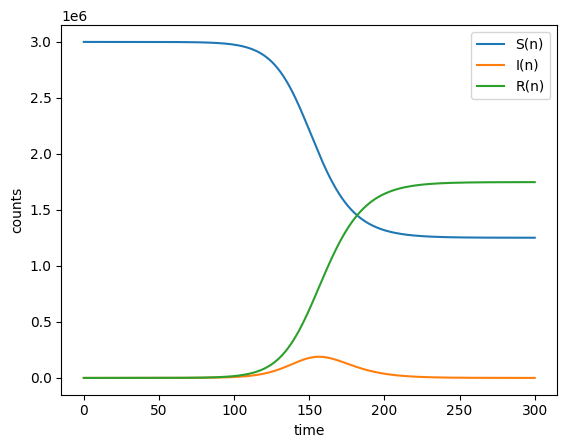

In [ ]:
# plot results
plt.plot(t_vec,sol[:,0])
plt.plot(t_vec,sol[:,1])
plt.plot(t_vec,sol[:,2])
plt.xlabel('time')
plt.ylabel('counts')
plt.legend(['S(n)', 'I(n)', 'R(n)'], loc='best')
plt.show()

We obtain the number of new cases each day

In [1]:
W=sol[0:grid_size-1,0]-sol[1:grid_size,0]

NameError: name 'sol' is not defined

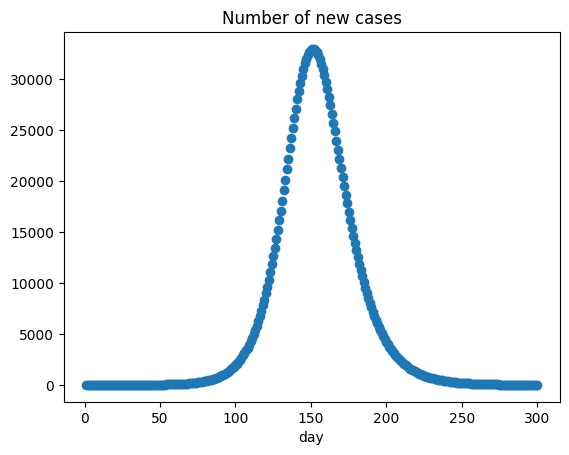

In [ ]:
plt.scatter(t_vec[1:grid_size],W)
plt.title('Number of new cases')
plt.xlabel('day')
plt.show()

In [ ]:
np.random.seed(123)
#y = np.random.poisson(W, len(W))
pp = 0.01
rr = pp/(1-pp)*W
y = np.random.negative_binomial(rr,pp, len(W))

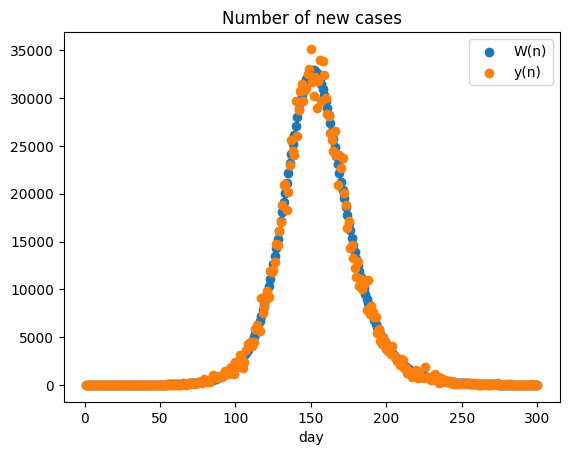

In [ ]:
plt.scatter(t_vec[1:grid_size],W)
plt.scatter(t_vec[1:grid_size],y)
plt.title('Number of new cases')
plt.xlabel('day')
plt.legend(['W(n)', 'y(n)'], loc='best')
plt.show()

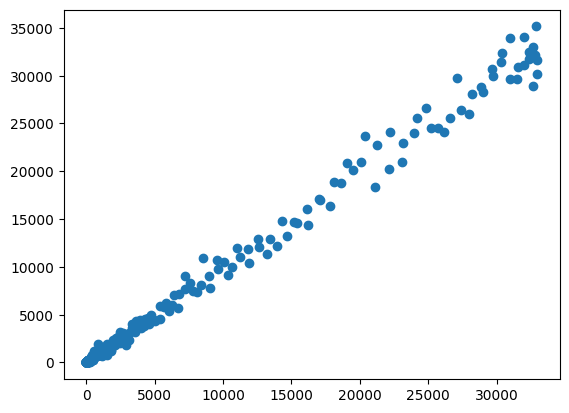

In [ ]:
plt.scatter(W,y)
plt.show()

## Model especification

**Model**

We have $n$ day of new cases for an outbreak ($y$). We consider that the outbreak in the population (with known size) evolve as an SIR model and that demographic changes are unimportant.

We assume that the observations have as mean the SIR model in [(1.1)](#equation-sir-system) but it also has important variations around this mean that we model as Poisson. Then the likelihood of the model is
$$
p(\boldsymbol{y}|\alpha,\phi)= \prod_{i=1}^N\binom{y_i+\alpha-1}{\alpha-1}\left(\frac{\phi}{\phi+1}\right)^\alpha\left(\frac{1}{\phi+1}\right)^{y_i}
$$
for $\alpha_i=W(i)\phi, \phi$. Thas is the mean of each $y_i$ is the number of new cases according to the SIR model [(1.1)](#equation-sir-system).

We could stablish a joint prior estimate, but we can start considering a prior where $\beta$ and $\gamma$ are independent:
\begin{align}
\pi(\beta) &\sim \text{Gamma}(\text{shape}=1.5, \text{scale}=10/5) \\
\pi(\gamma) &\sim \text{Gamma}(\text{shape}=1.5, \text{scale}=10/5) \\
\end{align}




**We plot the prior pdf**

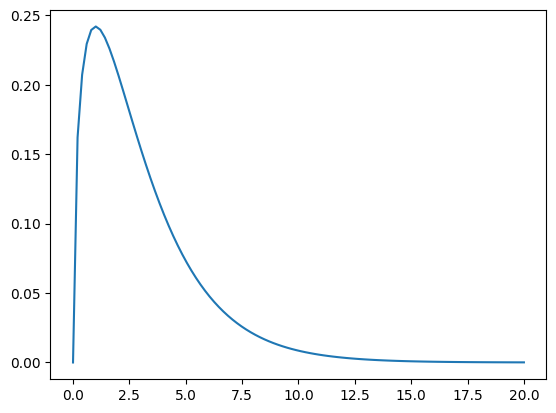

In [ ]:
from scipy.stats import gamma
x_ = np.linspace(0, 20, 100)
y_ = gamma.pdf(x_, 1.5, loc=0, scale=10/5)
plt.plot(x_,y_)
plt.show()

### Stan model

In [ ]:
SIR_stan2 = """
functions {
  array[] real diff(array[] real x) {   //This function is to compute the daily incidence
    int m = num_elements(x);
    array[m - 1] real result;
    for (i in 1:(m-1)) {
      result[i] = x[i] - x[i+1];
    }
    return result;
  }

  array[] real phi_diff(array[] real x, real phi, int n_obs) {   //This function is to compute the first parameter of bn
    int m = num_elements(x);
    array[m - 1] real result;
    for (i in 1:n_obs) {
       result[i] = phi * abs(diff(x)[i]);
       if(result[i]<1e-6){
          result[i] = 1e-6;
       }
    }
    return result;
  }

  vector SIR(        //This is the SIR model.
      real t,              // time
      vector x,      //state vector SIR
      vector theta  //parameters (beta, gamma)
      ) {
      real N = x[1]+x[2]+x[3];          //population size
      vector[3] dx_dt;
      dx_dt[1] = -(theta[1] * x[2] * x[1]) / N;
      dx_dt[2] =  theta[1] * x[2] * x[1] / N - theta[2] * x[2];
      dx_dt[3] = -(dx_dt[1] + dx_dt[2]);
      return dx_dt;
  }
}
data {
  int n_obs;                     // Number of days
  array[n_obs] int y;  // The observed data  (daily incidence)
  vector[3] x0;                           // Initial conditions (data)
  real t0;                     // Initial time point (zero)
  array[n_obs + 1] real ts;     // Time points that were sampled
}
transformed data {
}
parameters {
  vector[2]<lower=0> theta;
  real<lower=0> phi_inv;    //inverse of one NB's parameter
}
transformed parameters{
  real<lower=0> phi = 1. / phi_inv;
}
model {
  theta[1] ~ gamma(1.5,0.5); //beta
  theta[2] ~ gamma(1.5,0.5); //gamma
  array[n_obs+1] vector[3] x = ode_rk45(SIR, x0, t0, ts, theta); // Output from the ODE solver
  phi_inv ~ exponential(5);
  y ~ neg_binomial_2(phi_diff(x[ ,1],phi,n_obs), phi);
}
generated quantities {
  real R0 = theta[1] / theta[2];
  //real recovery_time = 1 / theta[2];
}
"""

with open("SIR2.stan", "w") as f:
    f.write(SIR_stan2)

Es importante notar que la decrlaración de funciones y variables cambia de versión a versión en Stan. Antes por ejemplo se usaba

```stan
  real x[3];
```
pero ahora
```stan
 array[] real x
```

### Stan data

In [ ]:
SIR_data = dict(
    n_obs = len(t_vec)-1,
    y = y,
    x0 = x0,
    t0 = -0.00000001,
    ts = t_vec,
)

In [ ]:
len(t_vec)

301

In [ ]:
SIR_data

{'n_obs': 300,
 'y': array([    0,     0,     5,     0,     0,     0,     0,     0,     0,
            0,     0,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,    16,
            0,     1,     0,     0,     0,    15,     0,    13,     2,
            0,     0,     8,     0,     1,     8,     0,     0,    16,
           11,     0,     2,     4,    37,    35,     1,    43,    73,
            9,     0,     6,    29,    29,   125,    42,    18,    16,
            1,   160,   217,    16,   148,   236,    97,   151,   204,
           58,   232,   316,   279,   349,   179,   585,   497,   301,
          455,   283,   585,  1007,   830,   811,   743,   892,   942,
          842,   987,  1495,  1282,  1165,  1393,  1885,  1444,  1184,
         2400,  1855,  2193,  3139,  3058,  1789,  2368,  3651,  4311,
         4418,  4538,  4065,  4486,  5862,  6249,  5984,  5685,  9097,
         7508,  8126,  9040,  9790,  9176, 11969, 11863, 

### Run

In [ ]:
with bebi103.stan.disable_logging():
    sm = cmdstanpy.CmdStanModel(stan_file="SIR2.stan")

    samples = sm.sample(
        data = SIR_data,
        chains = 2,
        iter_sampling = 500,
        show_console=True,
    )

Chain [1] method = sample (Default)
Chain [2] method = sample (Default)
Chain [1] sample
Chain [2] sample
Chain [2] num_samples = 500
Chain [2] num_warmup = 1000 (Default)
Chain [2] save_warmup = false (Default)
Chain [2] thin = 1 (Default)
Chain [2] adapt
Chain [2] engaged = true (Default)
Chain [2] gamma = 0.05 (Default)
Chain [2] delta = 0.8 (Default)
Chain [2] kappa = 0.75 (Default)
Chain [2] t0 = 10 (Default)
Chain [2] init_buffer = 75 (Default)
Chain [2] term_buffer = 50 (Default)
Chain [2] window = 25 (Default)
Chain [2] save_metric = false (Default)
Chain [2] algorithm = hmc (Default)
Chain [2] hmc
Chain [2] engine = nuts (Default)
Chain [2] nuts
Chain [2] max_depth = 10 (Default)
Chain [2] metric = diag_e (Default)
Chain [2] metric_file =  (Default)
Chain [2] stepsize = 1 (Default)
Chain [2] stepsize_jitter = 0 (Default)
Chain [2] num_chains = 1 (Default)
Chain [2] id = 2
Chain [2] data
Chain [2] file = /tmp/tmpttg4hwn0/3nz35nrj.json
Chain [2] init = 2 (Default)
Chain [2] rand

In [ ]:
samples.summary()

DEBUG:cmdstanpy:cmd: cmdstan-2.35.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmpttg4hwn0/stansummary-SIR2-b6iim5qx.csv /tmp/tmpttg4hwn0/SIR247s7zz2t/SIR2-20241009040038_1.csv /tmp/tmpttg4hwn0/SIR247s7zz2t/SIR2-20241009040038_2.csv
cwd: None


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-2108.890000,0.065593,1.169690,-2111.150000,-2108.570000,-2107.610000,317.99500,0.756874,1.00129
theta[1],0.252357,0.001357,0.019838,0.221731,0.250667,0.285973,213.70500,0.508647,1.00629
theta[2],0.169624,0.001468,0.021520,0.136364,0.168134,0.205888,215.00600,0.511745,1.00621
phi_inv,0.940290,0.004280,0.059280,0.845110,0.939380,1.034710,191.74445,0.456380,1.00834
phi,1.067720,0.004960,0.067170,0.965510,1.064720,1.183050,183.45668,0.436650,1.00762
R0,1.496930,0.004830,0.074060,1.388380,1.493270,1.627170,235.38019,0.560240,1.00552


In [ ]:
samples = az.from_cmdstanpy(posterior=samples)

### Saving the samples in Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import joblib
#joblib.dump(samples, 'samples.joblib')  #save to a file

samples = joblib.load('samples.joblib')  #load the pipeline from a file

FileNotFoundError: [Errno 2] No such file or directory: 'samples.joblib'

## Examining outputs

In [ ]:
# Print a summary of the posterior sample
type(samples)

arviz.data.inference_data.InferenceData

### Traceplots

In [ ]:
az.plot_trace(samples, var_names=["theta","phi"],backend="bokeh",figsize=[13,10],compact=False);

In [ ]:
bokeh.io.show(bebi103.viz.trace(samples,parameters=["theta[0]","theta[1]","phi" ,"R0"]))

### Parallel coordinate plots

Plots that visualize diagnostics effectively are better. We will talk more about diagnostics of MCMC in later lessons, but for now, I will display one of the diagnostic plots Dan showed in his talk. Here, we put the parameter names on the x-axis, and we plot the values of the parameters on the y-axis. Each line in the plot represents a single sample of the set of parameters.

To make sure we compare things of the same magnitude so we can better see the details of how the parameters vary with respect to each other, we scale the samples by the minimum and maximum values. (The following plot does not render properly, but the syntax below if how you would construct the plot.)

In [ ]:
az.plot_parallel(
    samples, var_names=["beta_p", "gamma_p", "phi"], backend="bokeh", norm_method="minmax"
);

In [ ]:
#with bebi103

bokeh.io.show(
    bebi103.viz.parcoord(
        samples,
        transformation="minmax",
        parameters=["beta_p", "gamma_p", "phi"],
    )
)

Intepretation of parallel coordinate plots

Normally, samples with problems are plotted in another color to help diagnose the problems. In this particular set of samples, there were no problems, so everything looks fine.

Interestingly, the "neck" between phi and gamma_ is indicative of anticorrelation. When φ is high, γ is low, and vice-versa.

### Plots of marginalized distributions

While we cannot in general plot a multidimensional distribution, we can plot marginalized distributions, either of one parameter or of two.

There are three main options for plotting marginalized distributions of a single parameter.

1. A kernel density estimate of the marginalized posterior.
2. A histogram of the marginalized posterior.
3. An ECDF of the samples out of the posterior for a particular parameter. This approximates the CDF of the marginalized distribution.

I prefer (3), though (2) is a good option as well. For continuous parameters, ArviZ offers only a KDE plot.

**Plotting marginalized distributions with ArviZ**

We already saw that ArviZ can give these plots along with trace plots. We can also directly plot them using the `az.plot_density()`. When using this function, the distributions are truncated at the bound of the **highest probability density region**, or **HPD**. If we're considering a 95% credible interval, the HPD interval is the shortest interval that contains 95% of the probability of the posterior. By default, `az.plot_density()` truncates the plot of the KDE of the PDF for a 94% HPD.

In [ ]:
az.plot_density(
    samples, var_names=["theta","phi"], backend="bokeh", backend_kwargs=dict(frame_width=200, frame_height=150)
);

**Plotting marginalized distributions with iqplot**

To get samples out of the marginalized posterior for a single parameter, we simply ignore the values of the parameters that are not the one of interest. We can then use iqplot to make plots of histograms or ECDFs.

To do so, we need to convert the posterior samples to a tidy data frame.

In [ ]:
# Convert to data frame
df_mcmc = bebi103.stan.arviz_to_dataframe(samples)

# Take a look
df_mcmc.head()

R0,phi,phi_inv,theta[0],theta[1],chain__,draw__,diverging__
f64,f64,f64,f64,f64,i64,i64,bool
1.52375,1.05536,0.947546,0.243591,0.159863,0,0,false
1.51535,1.05364,0.949091,0.243727,0.160839,0,1,false
1.53848,1.10646,0.903782,0.238922,0.155297,0,2,false
1.53881,1.10713,0.903235,0.239063,0.155355,0,3,false
1.53063,1.09148,0.916191,0.242064,0.158146,0,4,false


In [ ]:
hists = [
    iqplot.histogram(
        df_mcmc, q=param, density=True, rug=False, frame_height=150
    )
    for param in ["theta[0]","theta[1]", "phi"]
]

bokeh.io.show(bokeh.layouts.column(*hists))

In [ ]:
ecdfs = [
    iqplot.ecdf(
        df_mcmc, q=param, style="staircase", frame_height=150
    )
    for param in ["theta[0]","theta[1]", "phi"]
]

bokeh.io.show(bokeh.layouts.column(*ecdfs))

### Marginal posteriors of two parameters and corner plots

We can also plot the two-dimensional distribution (of most interest here are the parameters $\phi$ and $\gamma$). The simplest way to plot these is simply to plot each point, possibly with some transparency.

### Pair plots with ArviZ



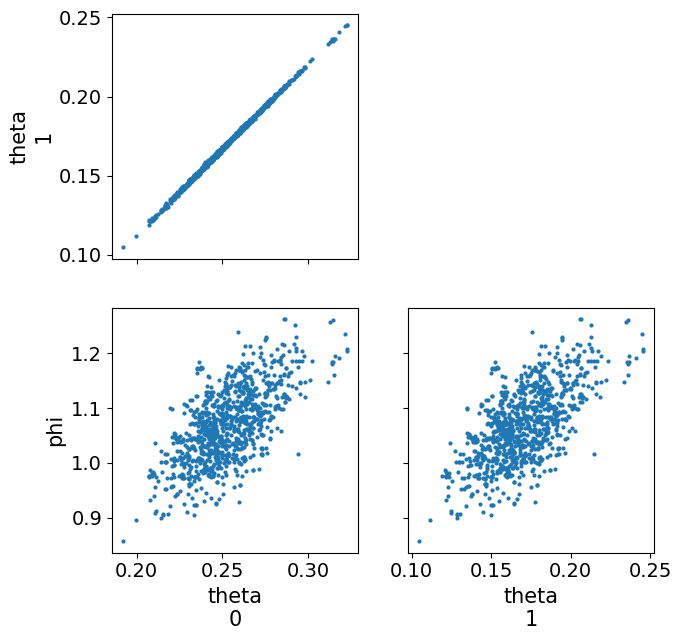

In [ ]:
az.plot_pair(
    samples,
    var_names=["theta", "phi"],
    figsize=[7,7],
);

By adding the marginals=True kwarg, the pair plots now also include representation of the univariate marginal distributions.

In [ ]:
az.plot_pair(
    samples,
    var_names=["theta", "phi"],
    marginals=True,
    backend="bokeh",
    backend_kwargs=dict(frame_width=200, frame_height=200),
);

A plot like this is often called a **corner plot**. It shows all bi- and uni-variate marginal distributions.

ArviZ also offers two-dimensional binning in the form of a hex plot.

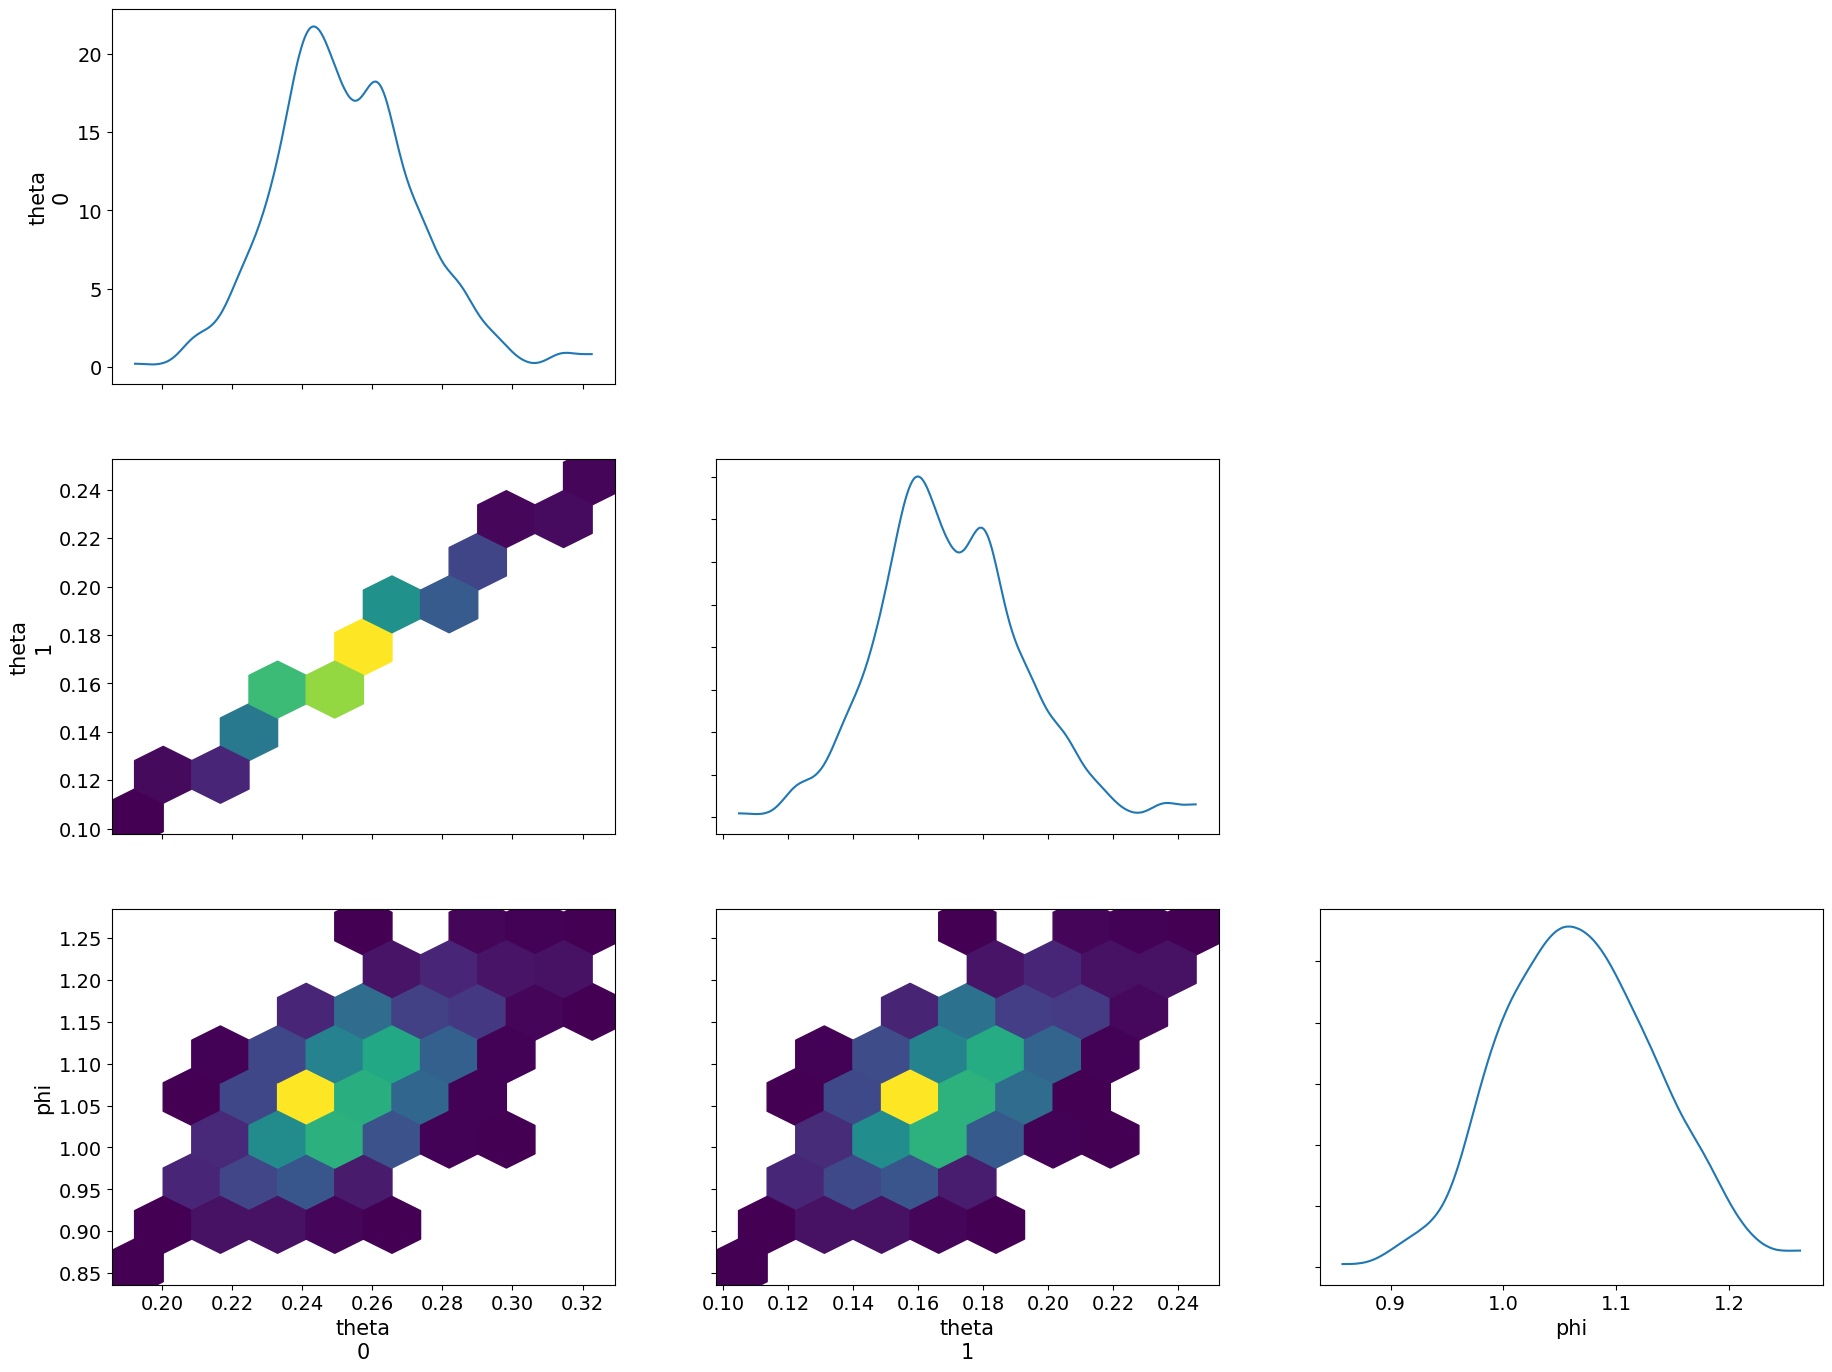

In [ ]:
az.plot_pair(
    samples,
    var_names=["theta", "phi"],
    kind="hexbin",
    marginals=True,
);

### Corner plots with bebi103

Corner plots are also implemented in the bebi103 package.

In [ ]:
bokeh.io.show(
    bebi103.viz.corner(
        samples,
        parameters=[("theta[0]", "β"), ("theta[1]", "γ"), ("phi", "ϕ")],
        xtick_label_orientation=np.pi / 4,
    )
)

This is a nice way to summarize the posterior and is useful for visualizing how various parameters covary. We can also do a corner plot with the one-parameter marginalized posteriors represented as CDFs.

In [ ]:
bokeh.io.show(
    bebi103.viz.corner(
        samples,
        parameters=[("theta[0]", "β"), ("theta[1]", "γ"), ("phi", "ϕ")],
        plot_ecdf=True,
        xtick_label_orientation=np.pi / 4,
    )
)

Corner plots are my preferred method of displaying results. All possible display-able marginal posteriors are plotted and laid out in a logical way.

In [ ]:
bebi103.stan.clean_cmdstan()